# Task 4: Manual Homography + Sticthing

In [3]:
import numpy as np
import scipy.linalg as linalg
import cv2
from PIL import Image
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import yaml
import cv2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
def getHomography(x1, x2, x3, x4, y1, y2, y3, y4):
    print(x1, x2, x3, x4, y1, y2, y3, y4)
    A = np.array([[x1[0],x1[1],1, 0,0,0, -x1[0]*y1[0],-x1[1]*y1[0],-y1[0]],
                  [0,0,0, x1[0],x1[1],1, -x1[0]*y1[1],-x1[1]*y1[1],-y1[1]],
                  [x2[0],x2[1],1, 0,0,0, -x2[0]*y2[0],-x2[1]*y2[0],-y2[0]],
                  [0,0,0, x2[0],x2[1],1, -x2[0]*y2[1],-x2[1]*y2[1],-y2[1]],
                  [x3[0],x3[1],1, 0,0,0, -x3[0]*y3[0],-x3[1]*y3[0],-y3[0]],
                  [0,0,0, x3[0],x3[1],1, -x3[0]*y3[1],-x3[1]*y3[1],-y3[1]],
                  [x4[0],x4[1],1, 0,0,0, -x4[0]*y4[0],-x4[1]*y4[0],-y4[0]],
                  [0,0,0, x4[0],x4[1],1, -x4[0]*y4[1],-x4[1]*y4[1],-y4[1]]])
#     print(A)
    U, D, Vt = linalg.svd(A)
    H = Vt[-1].reshape(3,3)
#     print(H)
    
    return H

In [5]:
%matplotlib tk
def choosePoints(img1, img2):

    matplotlib.use('TkAgg')

    imshow(img1, interpolation='none')
    chosenPoints1 = ginput(4) 
#     print(chosenPoints1)
    
    imshow(img2, interpolation='none')
    chosenPoints2 = ginput(4) 
#     print(chosenPoints2)
    
    return chosenPoints1, chosenPoints2

In [6]:
def getMinMax(array):
    print("getMinMax:")
    print(array[0,:])
    print("getMinMaxEnd")
    minX = np.min(array[0,:])
    minY = np.min(array[1,:])
    maxX = np.max(array[0,:])
    maxY = np.max(array[1,:])
    return minX, minY, maxX, maxY

In [7]:
# Testing block:
array = np.array([[1,-1,-10,9,8],[3,101,-9,0,7],[1,2,3,4,5]])
getMinMax(array)

getMinMax:
[  1  -1 -10   9   8]
getMinMaxEnd


(-10, -9, 9, 101)

In [73]:
def computeHomographyAndConcat(img1, img2):
    imgSizeX1 = img1.shape[0]
    imgSizeY1 = img1.shape[1]
    imgSizeX2 = img2.shape[0]
    imgSizeY2 = img2.shape[1]
    
    # read the chosen points:
    chosenPts1, chosenPts2 = choosePoints(img1, img2)
    
    H = getHomography(chosenPts1[0], chosenPts1[1], chosenPts1[2], chosenPts1[3],
                      chosenPts2[0], chosenPts2[1], chosenPts2[2], chosenPts2[3])
    HInverse = np.linalg.pinv(H)
    
    # get the orgPoses as an array of size 3*imgSize not an img:
    arrOrgPos = np.zeros((3,imgSizeX1*imgSizeY1))
    cnt = 0
    for i in range(0, imgSizeX1):
        for j in range(0, imgSizeX1):
            arrOrgPos[:,cnt] = HInverse.dot(np.array([i,j,1]))
            arrOrgPos[:,cnt] = arrOrgPos[:,cnt]/arrOrgPos[2,cnt]
            arrOrgPos[0,cnt] = int(arrOrgPos[0,cnt])
            arrOrgPos[1,cnt] = int(arrOrgPos[1,cnt])
#             print(arrOrgPos[0,cnt],arrOrgPos[1,cnt],arrOrgPos[2,cnt])
            cnt+=1
    # get the minimum and maximum poses of the orgPoses
    minX, minY, maxX, maxY = getMinMax(arrOrgPos)
    print(minX, minY, maxX, maxY)
    # shifting img1, shifting the maximum size of the canvas
    shiftX = 0
    shiftY = 0
    if minX < 0:
        arrOrgPos[0,:] += abs(minX)
        shiftX = int(abs(minX))
        maxX += abs(minX)
    if minY < 0:
        arrOrgPos[1,:] += abs(minY)
        shiftY = int(abs(minY))
        maxY += abs(minY)
    # get the new canvas
    newSizeX = int(maxX)+imgSizeX2
    newSizeY = int(maxY)+imgSizeY2
    newImg = np.zeros((newSizeX, newSizeY, 3),np.uint8)
    # prepare img2 on the new canvas
    for i in range(0,int(imgSizeX2)):
        for j in range(0,int(imgSizeY2)):
            newImg[i+shiftX][j+shiftY] = img2[i][j]   
    
    for i in range(0, newSizeY):
        for j in range(0, newSizeX):
            newPos = np.array([i, j, 1])
            orgPos = HInverse.dot(newPos) # find the corresponding indexes in the original image by H^(-1)
            orgPos = orgPos/orgPos[2] # normalize the indexes
            orgPosX = int(orgPos[0]) # round the indexes to integer
            orgPosY = int(orgPos[1]) 
            if((orgPosX >= 0 and orgPosX < imgSizeY1) and (orgPosY >= 0 and orgPosY < imgSizeX1)):
                if(j+shiftX < newSizeX and i+shiftY < newSizeY):
                    newImg[j+shiftX][i+shiftY] = img1[orgPosY][orgPosX]       
                
    # Draw img
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    plt.imshow(newImg/255)
    plt.show()

(22.811258278145658, 289.65452538631354) (281.0894039735099, 285.2395143487859) (13.981236203090475, 351.4646799116998) (267.84437086092714, 364.70971302428256) (325.23951434878586, 263.16445916114793) (563.6501103752759, 260.9569536423842) (316.4094922737306, 336.01214128035326) (557.0275938189844, 373.5397350993378)
getMinMax:
[-660. -660. -659. ...    0.    0.    0.]
getMinMaxEnd
-660.0 -68.0 211.0 519.0


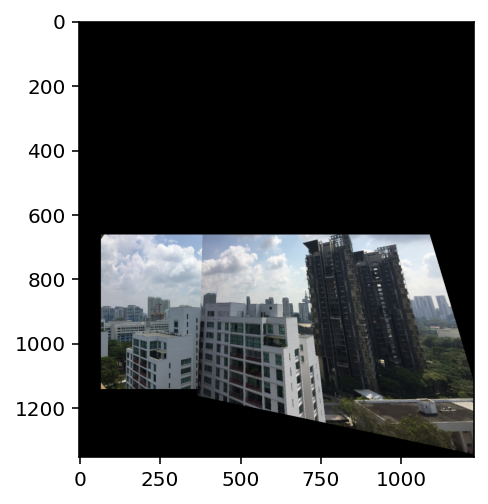

In [74]:
# Testing block
img1 = cv2.imread('im01.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('im02.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
computeHomographyAndConcat(img2, img1)

In [59]:
def computeHomographyAndConcat1(img1, img2):
    imgSizeX1 = img1.shape[0]
    imgSizeY1 = img1.shape[1]
    imgSizeX2 = img2.shape[0]
    imgSizeY2 = img2.shape[1]
#     newSizeX = img2.shape[0] * 2
#     newSizeY = img2.shape[1] * 2
#     newImg = np.zeros((newSizeX, newSizeY, 3),np.uint8)
    #     newSizeX = img2.shape[0]
    #     newSizeY = img2.shape[1]
    #     newImg = img2
    
#     # prepare img2 to the new Img:
#     for i in range(0,int(newSizeX/2)):
#         for j in range(0,int(newSizeY/2)):
#             newImg[i][j] = img2[i][j]

    
    # read the chosen points:
    chosenPts1, chosenPts2 = choosePoints(img1, img2)
    
    H = getHomography(chosenPts1[0], chosenPts1[1], chosenPts1[2], chosenPts1[3],
                      chosenPts2[0], chosenPts2[1], chosenPts2[2], chosenPts2[3])
#     HInverse = np.linalg.pinv(H)
    
    # get the orgPoses as an array of size 3*imgSize not an img:
    newPos = np.zeros((3,imgSizeX1*imgSizeY1))
    cnt = 0
    for i in range(0, imgSizeX1):
        for j in range(0, imgSizeX1):
            newPos[:,cnt] = H.dot(np.array([i,j,1]))
            newPos[:,cnt] = newPos[:,cnt]/newPos[2,cnt]
            newPos[0,cnt] = int(newPos[0,cnt])
            newPos[1,cnt] = int(newPos[1,cnt])
#             print(newPos[0,cnt],newPos[1,cnt],newPos[2,cnt])
            cnt+=1
    # get the minimum and maximum poses of the orgPoses
    minX, minY, maxX, maxY = getMinMax(newPos)
    print(minX, minY, maxX, maxY)
    # shifting img1, shifting the maximum size of the canvas
    shiftX = 0
    shiftY = 0
    if minX < 0:
        newPos[0,:] += abs(minX)
        shiftX = int(abs(minX))
        maxX += abs(minX)
    if minY < 0:
        newPos[1,:] += abs(minY)
        shiftY = int(abs(minY))
        maxY += abs(minY)
    # get the new canvas
    newSizeX = int(maxX)+imgSizeX2
    newSizeY = int(maxY)+imgSizeY2
    newImg = np.zeros((newSizeX, newSizeY, 3),np.uint8)
    # prepare img2 on the new canvas
    for i in range(0,int(imgSizeX2)):
        for j in range(0,int(imgSizeY2)):
            newImg[i+shiftY][j+shiftX] = img2[i][j]
    # loop to prepare img1 on the new canvas
    cnt = 0
    for i in range(0, imgSizeY1):
        for j in range(0, imgSizeX1):
            newPosX = int(newPos[0][cnt]) # round the indexes to integer
            newPosY = int(newPos[1][cnt])
            if((newPosX >= 0 and newPosX < newSizeY) and (newPosY >= 0 and newPosY < newSizeX)):
                newImg[newPosY][newPosX] = img1[j][i]
            cnt+=1     
                
    # Draw img
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    plt.imshow(newImg/255)
    plt.show()

(24.468140100047663, 289.5932831146706) (220.8888076964833, 283.98126404048674) (20.459555047059155, 371.3684181956356) (208.06133552692017, 381.7907393334057) (326.7154530953793, 265.5417727967397) (579.2563114336538, 257.5246026907627) (329.1206041271723, 333.6877186975439) (552.7996500839297, 367.3598331426472)
getMinMax:
[277. 277. 277. ...   0.   0.   0.]
getMinMaxEnd
0.0 -931.0 2199.0 638.0


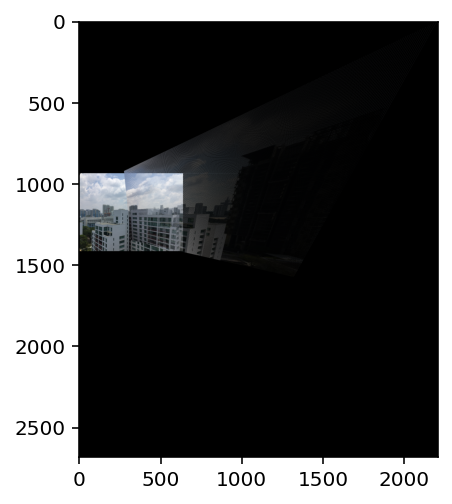

In [60]:
# Testing block
img1 = cv2.imread('im01.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('im02.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
computeHomographyAndConcat1(img2, img1)